# SENTIMENT ANALYSIS USING MULTILAYER BIDIRECTIONAL LSTM MODEL

## 1. Import statements

**Import necessary packages and modules**

In [1]:
import os
import time
import random
import math
import json
import pandas as pd
import numpy as np
import tensorflow as tf
import progressbar
tf.reset_default_graph()
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

**Import gensim**

In [2]:
from gensim.models.word2vec import Word2VecKeyedVectors

**Set the random seed of numpy and tensorflow**

In [3]:
# np_rand_seed = random.randint(0,100)
# tf_rand_seed = random.randint(0,100)
np_rand_seed = 95
tf_rand_seed = 63
np.random.seed(np_rand_seed)
tf.set_random_seed(tf_rand_seed)
print("numpy random seed: ",np_rand_seed)
print("tensorflow random seed: ", tf_rand_seed)

numpy random seed:  95
tensorflow random seed:  63


## 2. Load train data, test data, and gensim word2vec model

**Set some directories**

In [4]:
input_dir = "../input/yelp_review_polarity_csv/"
word2vec_dir = "./word2vec_models/"
model_dir = "./model_files/"
submission_dir = "./submission_dir/"

**Load the cleaned train and test data**

In [5]:
data = pd.read_csv(input_dir+'train_data_processed.csv') 
test_data = pd.read_csv(input_dir+'test_data_processed.csv')

In [6]:
data.head()

,sentiment,review,length
0,0,unfortun frustrat dr goldberg patient repeat e...,54
1,1,go dr goldberg 10 year think on 1st patient st...,39
2,0,know dr goldberg like move arizona let tell st...,101
3,0,write review give head see doctor offic staff ...,96
4,1,food great best thing wing wing simpli fantast...,46


In [7]:
test_data.head()

,sentiment,review,length
0,1,contrari review zero complaint servic price ge...,55
1,0,last summer appoint get new tire wait super lo...,34
2,1,friendli staff starbuck fair get anywher els s...,11
3,0,food good unfortun servic hit miss main issu s...,26
4,1,even car filen basement worth bu trip waterfro...,82


Unfortunately the csv loader function has problems, it occassionaly shows up null values for text columns. It is advised to get rid of the null values.

In [8]:
data = data.sample(frac=1,  random_state = np.random.seed()).reset_index(drop=True)
data = data[~data['review'].isnull()]
test_data = test_data[~test_data['review'].isnull()]

**Load the gensim model**

In [9]:
size = 300
window = 20
fname = "word2vec_size_"+str(size)+"_window_"+str(window)+".mdl"
model = Word2VecKeyedVectors.load_word2vec_format(word2vec_dir+fname)

## 3. Check the balance of the labels

**Extract the positive and negative sentiment examples**

In [10]:
pos_sent = data[data['sentiment'] == 1].shape[0]
neg_sent = data[data['sentiment'] == 0].shape[0]

**Bar chart of the balance of the sentiments**

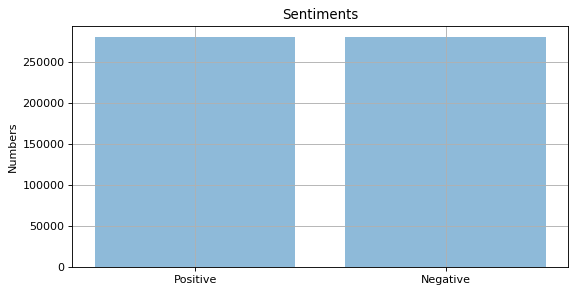

In [11]:
numbers = [pos_sent, neg_sent]
plt.figure(figsize=(8, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(np.arange(len(numbers)), numbers, align='center', alpha=0.5)
plt.xticks(np.arange(len(numbers)),\
           ['Positive', 'Negative'])
plt.ylabel('Numbers')
plt.title('Sentiments')
plt.grid()
plt.show()

## 4. Inspect the distribution of #words in the sentences

**Distribution of #words in train data**

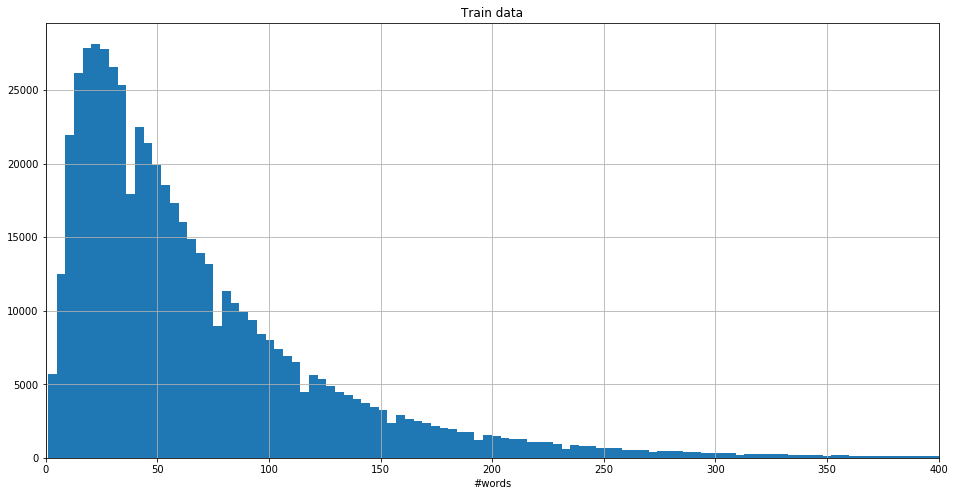

In [12]:
data.hist("length", bins=200, figsize=(16,8))
plt.title("Train data")
plt.xlabel("#words")
plt.xlim(0,400)
plt.show()

**Distribution of #words in test data**

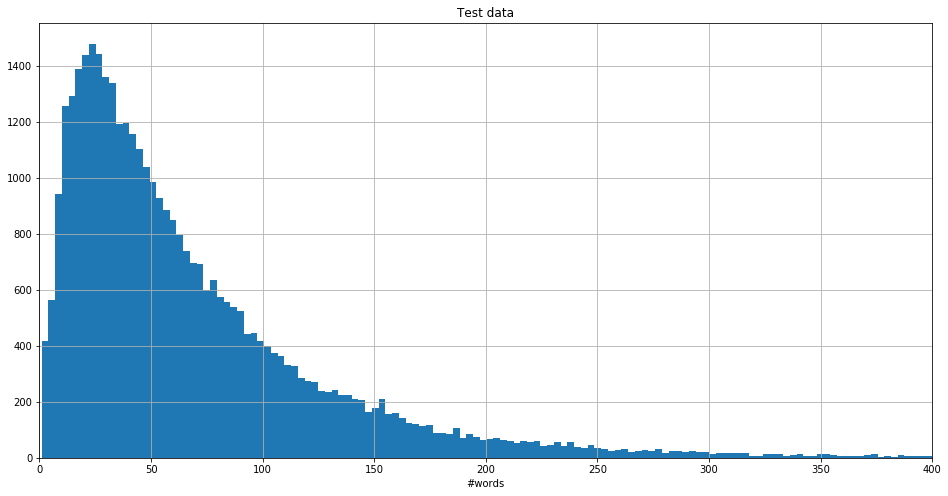

In [13]:
test_data.hist("length", bins=200, figsize=(16,8))
plt.title("Test data")
plt.xlabel("#words")
plt.xlim(0,400)
plt.show()

**Distribution of #words in all data**

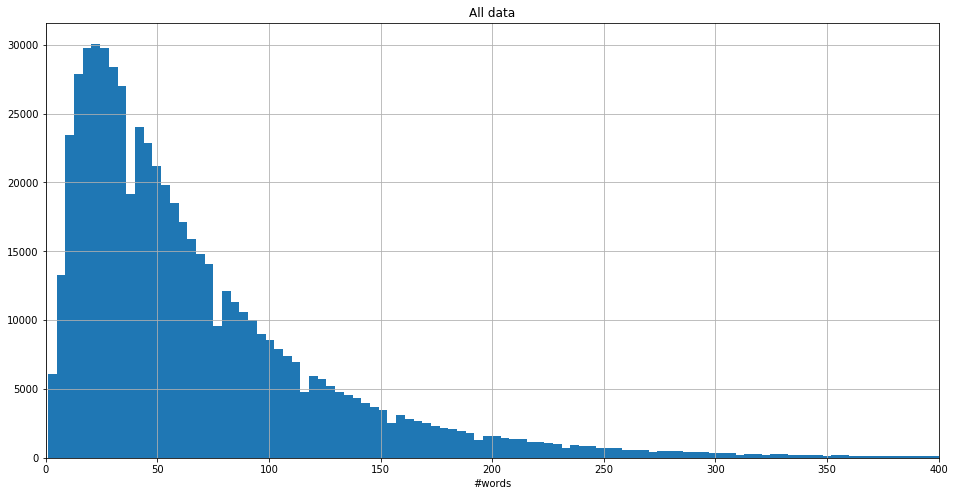

In [14]:
all_length = pd.concat([data['length'], test_data['length']])
all_length.hist(bins=200, figsize=(16,8))
plt.title("All data")
plt.xlim(0,400)
plt.xlabel("#words")
plt.show()
del(all_length)

**Split the training set into train and validation sets and save the sets**

In [15]:
test_size = test_data.shape[0]
test_data.to_csv(input_dir+"test_data.csv",header=True, index=False)
del(test_data)
train_percentage = 0.99 
train_data = data.head(int(len(data)*train_percentage))
train_data.to_csv(input_dir+"train_data.csv",header=True, index=False)
del(train_data)
valid_data = data.tail(len(data)-int(len(data)*train_percentage))
valid_size = len(valid_data)
valid_data.to_csv(input_dir+"valid_data.csv",header=True, index=False)
del(valid_data)
del(data)

## 5. Input functions

**A function to generate sequence of embeddings for the text columns**

In [16]:
def sequence_generator(comments, max_length, size):
    """
    A function to generate sequence of embeddings for the text columns
    """    
    sentences = []
    for comment in comments.tolist():
        sentences.append(str(comment).split())
        
    sequences = []
    for sentence in sentences:
        if len(sentence)>0:
            if len(sentence)<max_length:
                sequence = model[sentence]
                tail = np.zeros((max_length - len(sentence), size))
                sequence = np.concatenate((sequence, tail))
            else:
                sequence = model[sentence[:max_length]]
        else:
            sequence = np.zeros((max_length, size))        
        sequences.append(sequence)
    sequences = np.array(sequences)
    
    return sequences

**A function to generate batch of embeddings sequence, sequence length, and sentiments**

In [17]:
def generate_batch(reader, csv_path, batch_size, max_length, size, train_set=True):
    """
    A function to generate batch of embeddings sequence, sequence length, and one hot encode output
    """
    # read batch
    try:
        batch = reader.get_chunk()
    except:
        
        reader = pd.read_csv(csv_path, chunksize=batch_size)
        batch = reader.get_chunk()
    
    # extract columns of comments and sequence lengths
    review_batch = batch["review"].values
    seq_length_batch = batch["length"].values
    # if it is train set then extract the columns of sentiments
    if train_set:
        sentiments_batch = np.eye(2)[batch['sentiment'].values]
    # generate sequence of embeddings for the comments columns
    sequences_batch = sequence_generator(review_batch, max_length, size)
    
    if train_set:
        return sequences_batch, seq_length_batch, sentiments_batch
    else:
        return sequences_batch, seq_length_batch

## 6. Class module of multilayer lstm model

In [18]:
class multilayer_lstm_model(object):
    """
    Multilayer lstm model
    """    
    def __init__(self, n_steps, n_inputs, n_outputs, n_layers, 
                 n_neurons, dense_layers, learning_rate, device, tf_seed, np_seed):
        """
        Class constuctor which intializes the parameters, placeholders, and operations of the model
        """        
        # parameters of lstm model
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_layers = n_layers
        self.n_neurons = n_neurons
        self.dense_layers = dense_layers
        self.learning_rate = learning_rate
        self.device = device
        self.tf_seed = tf_seed
        self.np_seed = np_seed    
        
        # placeholders and operations
        self.X = None
        self.Y = None
        self.Length = None
        self.keep_prob = None
        self.Y_ = None
        self.accuracy = None
        self.cost = None
        self.train_step = None
        
        # create model
        self.X, self.Y, self.Length, self.keep_prob, \
        self.Y_, self.accuracy, self.cost, self.train_step = self.create_model()
        
        self.saver = None
        self.train_cost = None
        self.valid_cost = None
        self.valid_accuracy = None
        self.best_valid_accuracy = None
        self.best_iteration = None
        self.best_time = None
        self.log_of_computation_time = []
        
    
    def bidirectional_lstm(self, X, n_layers, n_neurons, keep_prob, device):
        
        """
        Method to create multilayer biderectional lstm model
        """
        output = X
        # iterate through the layers of LSTM
        for layer in range(n_layers):
            with tf.variable_scope('LSTM_Layer{}'.format(layer),reuse=tf.AUTO_REUSE):
                # forward lstm cell
                cell_fw = tf.nn.rnn_cell.LSTMCell(n_neurons,
                                                  initializer=tf.variance_scaling_initializer())
                # dropout on lstm cell
                cell_fw = tf.nn.rnn_cell.DropoutWrapper(cell_fw, input_keep_prob = keep_prob)
                # mount the lstm cell on gpu
                cell_fw = tf.nn.rnn_cell.DeviceWrapper(cell_fw,device) 
                # backward lstm cell
                cell_bw = tf.nn.rnn_cell.LSTMCell(n_neurons,
                                                  initializer=tf.variance_scaling_initializer())
                # dropout on lstm cell
                cell_bw = tf.nn.rnn_cell.DropoutWrapper(cell_bw, input_keep_prob = keep_prob)
                # mount the lstm cell on gpu
                cell_bw = tf.nn.rnn_cell.DeviceWrapper(cell_bw,device) 
                # extract the outputs and states bidirectional lstm
                outputs, states = tf.nn.bidirectional_dynamic_rnn(cell_fw, 
                                                                  cell_bw, 
                                                                  output,
                                                                  dtype=tf.float32)
                # concat the outputs of bidirectional lstm
                output = tf.concat(outputs,2)
        
        # concat the top layer h states of bidirection lstm 
        state = tf.concat([states[0][-1], states[1][-1]], axis=-1)

        return output, state
        
        
    def create_model(self):
        """
        A method to create the multilayer lstm model
        """
        # placeholder to store the input of the model
        X = tf.placeholder(tf.float32, [None, self.n_steps, self.n_inputs])
        # placeholder to store the output of the model
        Y = tf.placeholder(tf.float32, [None, self.n_outputs])
        # placeholder to store the lengths of the sequences
        Length = tf.placeholder(tf.int32, [None])
        # keep probability for dropout
        keep_prob = tf.placeholder(tf.float32)
        
        # created bidrectional lstm and extract the top layer h state
        _, top_layer_h_state = self.bidirectional_lstm(X, self.n_layers, self.n_neurons,
                                                       keep_prob, self.device)
        
        # iterate and create the dense layer
        for n, dense_layer in enumerate(self.dense_layers):
            # first dense layer (with dropout)
            if n == 0:
                with tf.device(self.device):
                    dense = tf.layers.dense(top_layer_h_state, dense_layer,
                                            kernel_initializer=tf.variance_scaling_initializer(),
                                            activation=tf.nn.elu)
                    dense = tf.nn.dropout(dense, keep_prob=keep_prob)
             # last dense layer (without dropout)
            elif n == len(self.dense_layers)-1:
                with tf.device(self.device):
                    dense = tf.layers.dense(dense, dense_layer,
                                            kernel_initializer=tf.variance_scaling_initializer())
            # middle dense layers (with droput)
            else:
                with tf.device(self.device):
                    dense = tf.layers.dense(dense, dense_layer, 
                                            kernel_initializer=tf.variance_scaling_initializer(),
                                            activation=tf.nn.elu)
                    dense = tf.nn.dropout(dense, keep_prob=keep_prob)
                    
        
        # compute predicted class
        Y_ = tf.argmax(dense, axis=1, output_type=tf.int32)
        # compute true class
        Y_true_cls = tf.argmax(Y, axis=1, output_type=tf.int32)
        # compute correct prediction
        correct_prediction = tf.equal(Y_, Y_true_cls)
        # compute accuracy
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        # cost
        with tf.device(device):
            cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=dense,labels=Y)
            cost = tf.reduce_mean(cross_entropy)

        # train step
        with tf.device(device):
            train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)        
        
        return X, Y, Length, keep_prob, Y_, accuracy, cost, train_step
    
    
    def train_model(self, max_iter, batch_size, drop_prob,
                    train_data_reader,valid_data_reader,train_path, valid_path,
                    max_length, size, model_dir, model_name, generate_batch):
        """
        A method to train the multilayer lstm model
        """        
        # generate sequences, length, & sentimentas for validation set
        sequences_valid, seq_length_valid, sent_valid = \
        generate_batch(valid_data_reader, valid_path, valid_data_reader.chunksize,
                       self.n_steps, self.n_inputs)
        # feed dict for validation
        feed_dict_validation =  {self.X:sequences_valid,
                                 self.Y:sent_valid,
                                 self.Length:seq_length_valid,
                                 self.keep_prob: 1.0} 
        
        # start time
        start_time = time.time()
        # create a saver object
        saver = tf.train.Saver(max_to_keep=1)
        # lists to store the train cost, validation cost, and validation accuracy
        train_cost = []
        valid_cost = []
        valid_accuracy = []
        # variables to store the best roc and best iteration
        # and the time to reach the best roc
        best_valid_accuracy = 0
        best_iteration = None
        best_time = None
        # path of model saver object
        model_path = model_dir+model_name
        
        # create a graph session and optimize the network under it
        with tf.Session() as sess:
            
            tf.set_random_seed(self.tf_seed)
            np.random.seed(self.np_seed)
        
            sess.run(tf.global_variables_initializer())
            sess.run(tf.local_variables_initializer())
            
            # create an object of progress bar
            bar = progressbar.ProgressBar(maxval=max_iter, widgets=[
                '[',progressbar.Percentage(),']',
                progressbar.Bar(),
                '(',progressbar.DynamicMessage("train_cost"),')',
                '(',progressbar.DynamicMessage("valid_cost"),')',
                '(',progressbar.DynamicMessage("valid_accuracy"),')',
                '(',progressbar.DynamicMessage("best_valid_accuracy"),')',
                '(',progressbar.DynamicMessage("time_elapsed"),'mins)'
            ])
            # start the progress bar
            bar.start()
            # counter variable to track the number of iterations
            counter = 0
            # iterate until maximum number of iterations is reached
            while True:
                # break out of the inner for loop if maximum number of iterations is reached
                if counter>=max_iter:
                    break            
                # generate sequences, length, & sentimentas for validation set
                sequences_batch, seq_length_batch, sent_batch = \
                generate_batch(train_data_reader, train_path, 
                               batch_size, self.n_steps, self.n_inputs)
                # feed dict for validation
                feed_dict_batch =  {self.X:sequences_batch,
                                    self.Y:sent_batch,
                                    self.Length:seq_length_batch,
                                    self.keep_prob: drop_prob} 
                # execute optimization step
                sess.run(self.train_step, feed_dict=feed_dict_batch)
                # calculate temporary train cost and append it to the designated list
                temp_train_cost = self.cost.eval(session=sess,
                                                 feed_dict=feed_dict_batch)
                train_cost.append(temp_train_cost)
                # calculate temporary validation cost and append it to the designated list
                temp_valid_cost = self.cost.eval(session=sess,
                                                 feed_dict=feed_dict_validation)
                valid_cost.append(temp_valid_cost)
                # calculate temporary validation cost and append it to the designated list
                temp_valid_acc = self.accuracy.eval(session=sess,
                                                    feed_dict=feed_dict_validation)
                valid_accuracy.append(temp_valid_acc)
                # compute running time from start point
                time_diff = (time.time()-start_time)/60
                # append elapsed time to the designated list
                self.log_of_computation_time.append(time_diff)
                # if valid cost is better than best recorded so far then
                # update the parameters of the best model and save the model
                if temp_valid_acc > best_valid_accuracy:
                    best_time = time_diff
                    best_valid_accuracy = temp_valid_acc
                    best_iteration = counter+1
                    saver.save(sess, model_path, global_step = best_iteration)
                    
                # store the required variables, placeholders and operations in designated class fields
                self.saver = saver
                self.train_cost = train_cost
                self.valid_cost = valid_cost
                self.best_valid_accuracy = best_valid_accuracy
                self.valid_accuracy = valid_accuracy
                self.best_iteration = best_iteration
                self.best_time = best_time

                # update the progress bar
                bar.update(counter+1, train_cost = temp_train_cost, 
                           valid_cost = temp_valid_cost,
                           valid_accuracy = temp_valid_acc, 
                           best_valid_accuracy = best_valid_accuracy, 
                           time_elapsed = time_diff)
                # increment counter variable
                counter += 1

            # finish the progress bar
            bar.finish()            
        
        
    def create_predictions(self, model_path, test_data_reader, test_path, 
                           n_folds, submission_dir, submission_file):
        """
        A function to compute predictions and submission file
        """
        # submission path
        submission_path = submission_dir + submission_file

        with tf.Session() as sess: 
            # restore the best model
            self.saver.restore(sess, model_path)
            # array to store the prediction
            preds = np.array([])
            # create a progress bar object
            bar = progressbar.ProgressBar(maxval=n_folds, widgets=[
                            '[',progressbar.Percentage(),']',
                            progressbar.Bar(),
                            '(',progressbar.DynamicMessage("number_of_folds_completed"),')'
                        ])            
            # start progress bat
            bar.start()
            
            # iterate through each fold
            for i in range(n_folds):
                # generate sequences, length, & sentiments for test set
                sequences_test, seq_length_test = \
                generate_batch(test_data_reader, test_path, test_data_reader.chunksize,
                               self.n_steps, self.n_inputs, train_set=False)
                # feed dict for test
                feed_dict_test =  {self.X:sequences_test,
                                   self.Length:seq_length_test,
                                   self.keep_prob: 1.0} 
                # evaluate predictions of the fold
                fold_preds = self.Y_.eval(session=sess, feed_dict = feed_dict_test)
                # append it to designated array
                preds = np.append(preds, fold_preds)                    
                # update the progress bar
                bar.update(i+1, number_of_folds_completed = i+1)                
            # finish the progress bar
            bar.finish()

            submission = pd.DataFrame({"sentiments": preds})
            submission.to_csv(submission_path, header = True, index=False)

## 7. Create graph of multilayer lstm model

**Inspect the devices of kernel**

In [19]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
print(devices)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17234949158975884036
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15864515789
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7925254383878357368
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


**Set the device to gpu if available**

In [20]:
if len(devices)>1:
    device = devices[-1].name
else:
    device = devices[0].name

**Create graph**

In [21]:
n_layers = 2
n_neurons = 128
max_length = n_steps = 250 
n_inputs = size
n_outputs = 2
dense_layers = [16,n_outputs]
learning_rate = (1e-3)*1
tf.reset_default_graph()
sequence_model = multilayer_lstm_model(n_steps, n_inputs, n_outputs, n_layers, 
                                       n_neurons, dense_layers, learning_rate,
                                       device, tf_rand_seed, np_rand_seed)

## 8. Train multilayer lstm model

**Train model**

In [22]:
max_iter = 500
batch_size = 200
keep_prob = 0.50
train_path = input_dir+"train_data.csv"
train_data_reader = pd.read_csv(train_path, chunksize=batch_size)
valid_path = input_dir+"valid_data.csv"
valid_data_reader = pd.read_csv(valid_path, chunksize=valid_size)
model_name = "multilayer_lstm" 
sequence_model.train_model(max_iter, batch_size, keep_prob,
                           train_data_reader,valid_data_reader,train_path, valid_path,
                           max_length, size, model_dir, model_name, generate_batch)

[100%]||(train_cost:  0.211)(valid_cost:  0.232)(valid_accuracy:  0.902)(best_valid_accuracy:  0.917)(time_elapsed:   44.9mins)


**Plot of cost vs iterations**

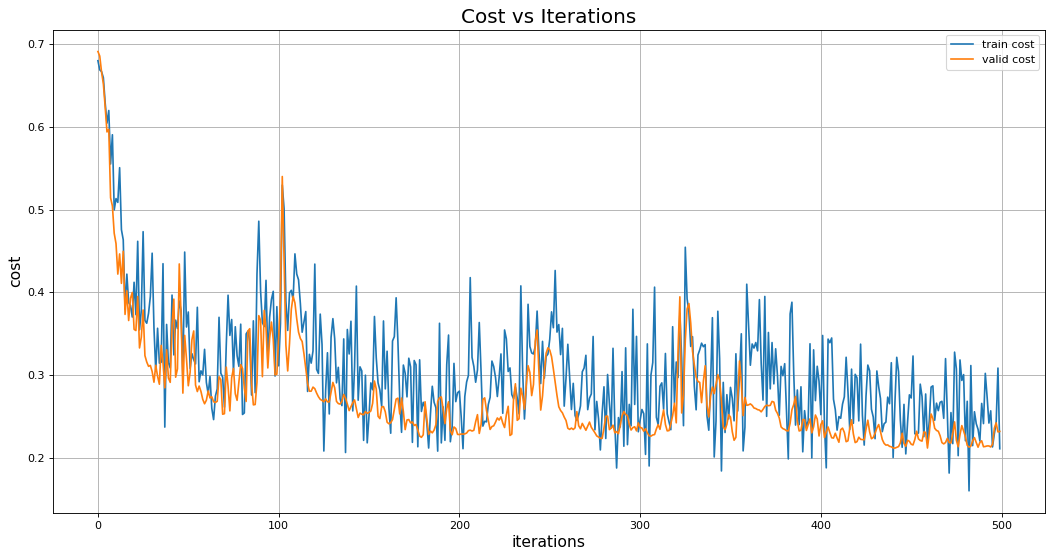

In [23]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(sequence_model.train_cost, label = 'train cost')
plt.plot(sequence_model.valid_cost, label = 'valid cost')
plt.xlabel('iterations', fontsize = 14)
plt.ylabel('cost', fontsize = 14)
plt.title("Cost vs Iterations",fontsize = 18)
plt.legend()
plt.grid()
plt.show()

**Plot of accuracy vs iterations**

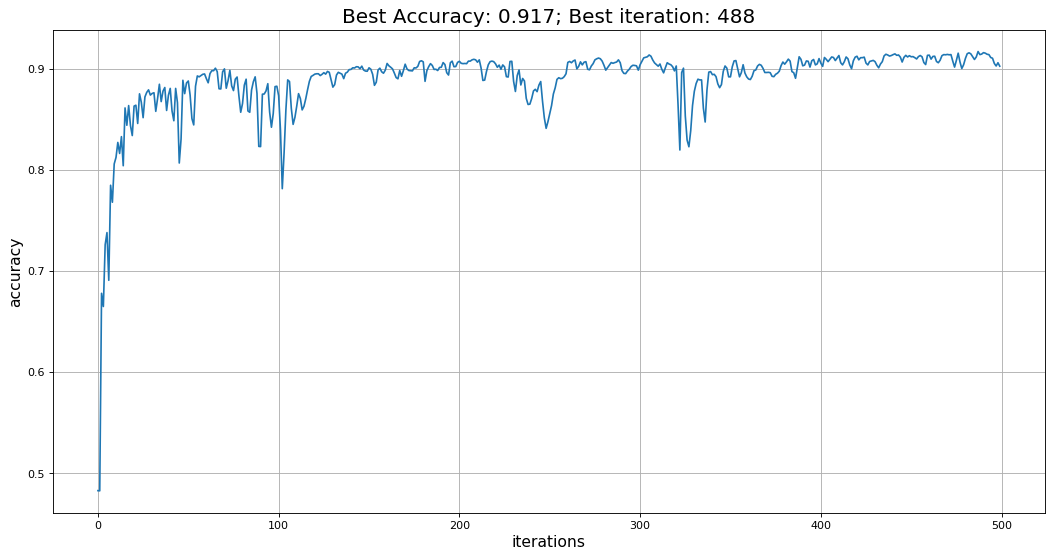

In [28]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(sequence_model.valid_accuracy)
plt.title("Accuracy vs Iterations")
plt.xlabel('iterations', fontsize = 14)
plt.ylabel('accuracy', fontsize = 14)
plt.title("Best Accuracy: "+str(round(sequence_model.best_valid_accuracy,3))+ \
          "; Best iteration: "+str(sequence_model.best_iteration),fontsize = 18)
plt.grid()
plt.show()

## 9. Create submission csv file and analyse results

**Create submission file**

In [25]:
n_folds = 100
test_batch_size = test_size//n_folds
if test_size%n_folds != 0: n_folds +=1
submission_file = "submission.csv"
test_path = input_dir+"test_data.csv"
test_data_reader = pd.read_csv(test_path, chunksize=test_batch_size)
model_path = model_dir+model_name+"-"+str(sequence_model.best_iteration)
sequence_model.create_predictions(model_path, test_data_reader, test_path, 
                                  n_folds, submission_dir, submission_file)

INFO:tensorflow:Restoring parameters from ./model_files/multilayer_lstm-488


[100%]|####################################|(number_of_folds_completed:    101)


**Compute output and predictions**

In [26]:
output = pd.read_csv(input_dir+"test_data.csv")['sentiment'].values
predictions = pd.read_csv(submission_dir+"submission.csv")['sentiments'].values

**Compute accuracy, precision, and recall of the model**

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print("Test accuracy:", round(accuracy_score(output, predictions),3))
print("Test precision:", round(precision_score(output, predictions),3))
print("Test recall:", round(recall_score(output, predictions),3))

Test accuracy: 0.913
Test precision: 0.91
Test recall: 0.917
